# Proyecto 1

Con el proposito de determinar la elegibilidad de un paciente para ensayos clínicos de cáncer a partir de
texto descriptivo se realizó el siguiente notebook.

## 0. Importación de Datos y Librerías

In [ ]:
# Instalación de librerias
%matplotlib inline

import sklearn
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

import sys

import re, string, unicodedata
!pip install contractions
!pip install inflect
import contractions
import inflect

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


import sklearn.model_selection as model_selection
from sklearn import svm,tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve,accuracy_score, f1_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Creación de funciones para la limpieza posterior de los datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/BI/Proyecto 1/datos_elegibilidad.csv'
df = pd.read_csv(path, sep=',', encoding = 'ISO-8859-1', index_col=None)
data = df

Mounted at /content/drive


In [5]:
print(data.shape)

(12000, 2)


In [6]:
data

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...
...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...
11996,__label__0,study interventions are Bevacizumab . recurren...
11997,__label__1,"study interventions are Antibodies, Monoclonal..."
11998,__label__0,study interventions are Vorinostat . colorecta...


## 1. Exploración y perfilamiento de datos

En esta sección se realizara la exploración y el perfilamiento inicial de los datos

In [7]:
from pandas_profiling import ProfileReport
data_report = data.copy()
data_report['Conteo'] = [len(x) for x in data_report['study_and_condition']]
data_report['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in data_report['study_and_condition']]
data_report['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in data_report['study_and_condition']]

ProfileReport(data_report)

TypeError: ignored

## 2. Limpieza de los datos

In [8]:
from nltk.corpus import stopwords
Stop_words = stopwords.words('english')
Stop_words.extend(('.', '-', '’s', ':', ',', '“', '”', '(', ')', '"', '\n', '—', '–', '?'))

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in Stop_words:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 2.1 Tokenización

In [9]:
nltk.download('punkt')
data_report['study_and_condition'] = data_report['study_and_condition'].apply(contractions.fix)
data_report['words'] = data_report['study_and_condition'].apply(word_tokenize).apply(preprocessing)
data_report.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,label,study_and_condition,Conteo,Max,Min,words
0,__label__0,study interventions are Saracatinib . recurren...,250,15,1,"[study, interventions, saracatinib, recurrent,..."
1,__label__1,study interventions are Stem cell transplantat...,224,15,1,"[study, interventions, stem, cell, transplanta..."
2,__label__0,study interventions are Lenograstim . recurren...,229,13,1,"[study, interventions, lenograstim, recurrent,..."
3,__label__0,study interventions are Doxorubicin . stage ii...,268,13,1,"[study, interventions, doxorubicin, stage, iii..."
4,__label__1,study interventions are Poly I-C . prostate ca...,232,15,1,"[study, interventions, poly, ic, prostate, can..."


### 2.2 Normalización

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stem_words(words):
    new_words = []
    ps = PorterStemmer()
    for word in words:
        new_words.append(ps.stem(word))
    return new_words


def lemmatize_verbs(words):
    new_words = []
    lemmatizer = WordNetLemmatizer()
    for word in words:
        new_words.append(lemmatizer.lemmatize(word))
    return new_words

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data_report['words'] = data_report['words'].apply(stem_and_lemmatize)
data_report.head()

,label,study_and_condition,Conteo,Max,Min,words
0,__label__0,study interventions are Saracatinib . recurren...,250,15,1,"[studi, intervent, saracatinib, recurr, verruc..."
1,__label__1,study interventions are Stem cell transplantat...,224,15,1,"[studi, intervent, stem, cell, transplant, hod..."
2,__label__0,study interventions are Lenograstim . recurren...,229,13,1,"[studi, intervent, lenograstim, recurr, adult,..."
3,__label__0,study interventions are Doxorubicin . stage ii...,268,13,1,"[studi, intervent, doxorubicin, stage, iii, di..."
4,__label__1,study interventions are Poly I-C . prostate ca...,232,15,1,"[studi, intervent, poli, ic, prostat, cancer, ..."


### 2.3 Preprocesamiento y vectorización de textos

In [11]:
#Aqui obtenemos el vocabulario de nuestros textos en el arreglo Vocab
def concatenate(arr):
    dicti = []
    for words in arr:
      for word in words:
        palabras = word.split(' ')
        for palabra in palabras:     
            if palabra not in dicti:
                dicti.append(palabra)
    return dicti


vocab = concatenate(np.asarray(data_report['words']))

In [ ]:
np.size(vocab)

10783

In [ ]:
comment_words_0 = ''
for index, row  in data_report.iterrows():
    if(row['label']=='__label__0'):
      content = row['words']
      string = ' '.join(content)
        # typecaste each val to string
      string = str(string)
      comment_words_0 += string
comment_words_1 = ''
for index, row  in data_report.iterrows():
    if(row['label']=='__label__1'):
      content = row['words']
      string = ' '.join(content)
        # typecaste each val to string
      string = str(string)
      comment_words_1 += string

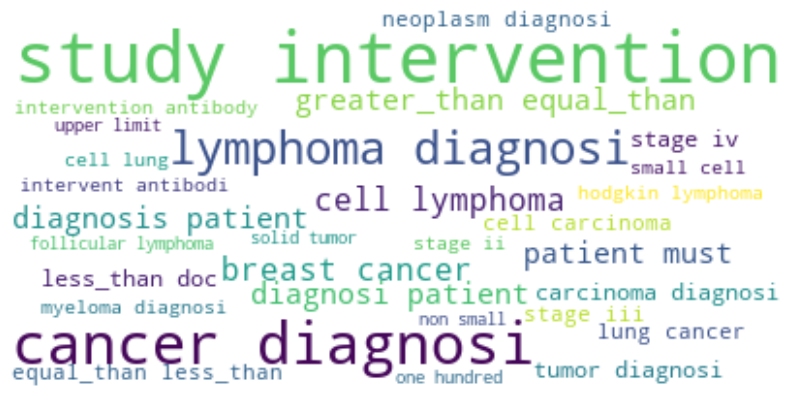

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white").generate(comment_words_0)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

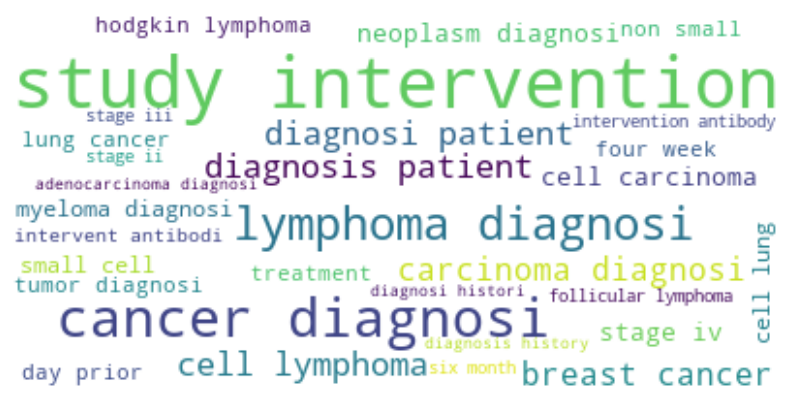

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white").generate(comment_words_1)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
#Dejamos la columna words como una cadena de texto y no como un array
data_report['words'] = data_report['words'].apply(lambda x: ' '.join(map(str, x)))
data_report

,label,study_and_condition,Conteo,Max,Min,words
0,__label__0,study interventions are Saracatinib . recurren...,250,15,1,studi intervent saracatinib recurr verruc carc...
1,__label__1,study interventions are Stem cell transplantat...,224,15,1,studi intervent stem cell transplant hodgkin l...
2,__label__0,study interventions are Lenograstim . recurren...,229,13,1,studi intervent lenograstim recurr adult diffu...
3,__label__0,study interventions are Doxorubicin . stage ii...,268,13,1,studi intervent doxorubicin stage iii diffus l...
4,__label__1,study interventions are Poly I-C . prostate ca...,232,15,1,studi intervent poli ic prostat cancer diagnos...
...,...,...,...,...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...,146,16,1,studi intervent prednisolon hemisuccin recurr ...
11996,__label__0,study interventions are Bevacizumab . recurren...,155,13,1,studi intervent bevacizumab recurr rectal canc...
11997,__label__1,"study interventions are Antibodies, Monoclonal...",136,16,1,studi intervent antibodi monoclon recurr lymph...
11998,__label__0,study interventions are Vorinostat . colorecta...,157,13,1,studi intervent vorinostat colorect cancer dia...


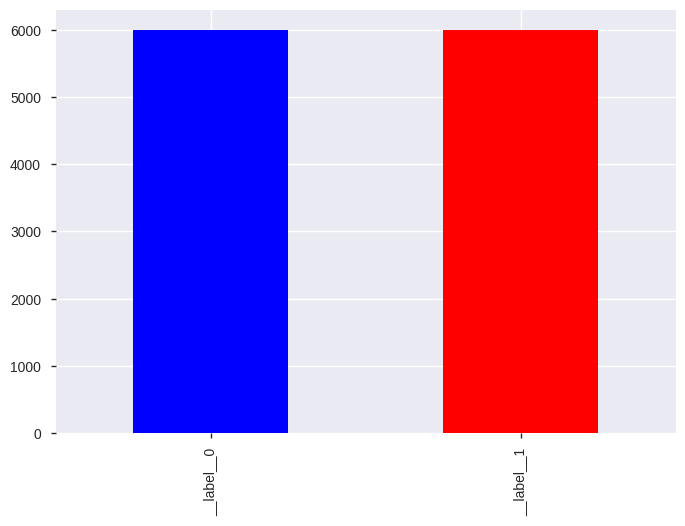

In [ ]:
data_report['label'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [ ]:
#Separamos la variable objetivo y los textos
X_data, y_data = data_report['words'],data_report['label']
y_data = (y_data == '__label__1').astype(int)
y_data

0        0
1        1
2        0
3        0
4        1
        ..
11995    0
11996    0
11997    1
11998    0
11999    0
Name: label, Length: 12000, dtype: int64

In [ ]:
X_data

0        studi intervent saracatinib recurr verruc carc...
1        studi intervent stem cell transplant hodgkin l...
2        studi intervent lenograstim recurr adult diffu...
3        studi intervent doxorubicin stage iii diffus l...
4        studi intervent poli ic prostat cancer diagnos...
                               ...                        
11995    studi intervent prednisolon hemisuccin recurr ...
11996    studi intervent bevacizumab recurr rectal canc...
11997    studi intervent antibodi monoclon recurr lymph...
11998    studi intervent vorinostat colorect cancer dia...
11999    studi intervent freund adjuv ovarian cancer di...
Name: words, Length: 12000, dtype: object

In [ ]:
data_report.to_csv('datos_limpios.csv') 

### 2.4 Generación de Datos Finales

#### 2.4.1 Opcion 1: Conteo de palabras presentes con Count Vectorizer

In [ ]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)

In [ ]:
X_count.toarray()

#### 2.4.2 Opcion 2: TF_IDF para vectorizar

In [ ]:
def tfidf(word, sentence):
    tf = sentence.count(word) / len(sentence)
    idf = np.log10(len(X_data) / sum([1 for doc in X_data if word in doc]))
    return round(tf*idf, 4)

#Aqui podemos ver que el metodo esta bien implementado. La palabra saracatinib solo se encuentra en la primer cadena, luego
#es correcto que esta sea la única cadena con tfidf mayor a 0.
print(tfidf('saracatinib', X_data[0]))
print(tfidf('saracatinib', X_data[1]))
print(tfidf('saracatinib', X_data[2]))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizerTfid = TfidfVectorizer()
X = vectorizerTfid.fit_transform(X_data)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, y_data, test_size=0.25, random_state=0)

## 3. Modelos

### 3.1 Naive Bayes

In [ ]:
#NAIVE BAYES
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train.toarray(), Y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=10)
}
scorer = sklearn.metrics.make_scorer(sklearn.metrics.recall_score)
nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1, scoring = scorer)
nbModel_grid.fit(X_train.toarray(), Y_train)
print(nbModel_grid.best_estimator_)

In [ ]:
prediction = nbModel_grid.predict(X_test.toarray())
#prediction = gnb.predict(X_test.toarray())
print('Score for Support Vector Machine - Train: ', accuracy_score(Y_test, prediction))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction), ": is the confusion matrix")
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, prediction), ": is the accuracy score")
from sklearn.metrics import precision_score
print(precision_score(Y_test, prediction), ": is the precision score")
from sklearn.metrics import recall_score
print(recall_score(Y_test, prediction), ": is the recall score")
from sklearn.metrics import f1_score
print(f1_score(Y_test, prediction), ": is the f1 score")

### 3.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score,plot_confusion_matrix
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, Y_train)


y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))
print("Recall: {}".format(recall_score(Y_test,y_pred_test, average=None)))

In [ ]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini','entropy'],'n_estimators':[2,3,4,5,6,7,8,9,10],'max_depth':[2,3,4,5,6]}

In [ ]:
import sklearn
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = RandomForestClassifier(random_state=0)

scorer = sklearn.metrics.make_scorer(sklearn.metrics.recall_score, average = "weighted")

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones, scoring = scorer)
# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

In [ ]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.

y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)

print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))
print("Recall: {}".format(recall_score(Y_test,y_pred_test, average=None)))

In [ ]:
# Finalmente se hace un tunning manual para mejorar generalización sobre test en la clase de interés (2)
arbol_final = RandomForestClassifier(criterion='entropy', max_depth=5)
arbol_final = arbol_final.fit(X_train, Y_train)
y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))
print("Recall sobre entrenamiento: {}".format(recall_score(Y_train, y_pred_train, average=None)))
print("--> Recall sobre test: {}".format(recall_score(Y_test, y_pred_test, average=None)))
plot_confusion_matrix(arbol_final, X_test, Y_test)  
plt.show() 
print("SOBRE TEST")
print(classification_report(Y_test, y_pred_test))
print("SOBRE TRAIN")
print(classification_report(Y_train, y_pred_train))

In [ ]:
print(confusion_matrix(Y_test, y_pred_test), ": is the confusion matrix")


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred_test), ": is the accuracy score")
from sklearn.metrics import precision_score
print(precision_score(Y_test, y_pred_test), ": is the precision score")
from sklearn.metrics import recall_score
print(recall_score(Y_test, y_pred_test), ": is the recall score")
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_pred_test), ": is the f1 score")

### 3.3 SVM

Como tercer algoritmo, vamos a implementar un algoritmo basado en máquinas de vectores de soporte para solucionar el presente problema de clasificación.

In [ ]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm = svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)
print(classification_report(Y_test, y_pred))

Una primera prueba para la utilización de este tipo de modelo fue el uso de SVC con una función de kernel lineal. A grandes rasgos, esta función de kernel determina la dimensión en la cual se hace la partición en cada clase del problema. Como obtenemos buenos resultados, realizamos una busqueda de paramétros para determinar si es posible mejorar los resultados de la función de Kernel Lineal.

In [ ]:
from sklearn.svm import SVC
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,Y_train)
print(grid.best_estimator_)

In [ ]:
grid.best_params_

In [ ]:
Y_pred = grid.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))

In [ ]:
svm = SVC(C=10, gamma=1, kernel='rbf')
svm = svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)
print(classification_report(Y_test, y_pred))

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred), ": is the accuracy score")
from sklearn.metrics import precision_score
print(precision_score(Y_test, y_pred), ": is the precision score")
from sklearn.metrics import recall_score
print(recall_score(Y_test, y_pred), ": is the recall score")
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_pred), ": is the f1 score")